In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os
import nltk.data

In [2]:
nltk.download('punkt_tab')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/zlovoblachko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
json_thingie = []

In [7]:
errors_correspondence = {'Capitalisation': 'ORTH',
                         'Formational_affixes': 'FORM',
                         'Derivation': 'FORM',
                         'Noun_number': 'FORM', 
                         'Countable_uncountable': 'FORM',
                         'Category_confusion': 'MORPH',
                         'Articles': 'DET',
                         'Determiners': 'DET',
                         'Prepositional_noun': 'POS', # PREP
                         'Prepositions': 'POS', # PREP
                         'Verb_pattern': 'POS', # PREP
                         'Conjunctions': 'POS', # CONJ
                         'Pronouns': 'POS', # PRON
                         'Tense_choice': 'VERB', 
                         'Tense_form': 'VERB',
                         'Voice': 'VERB',
                         'Modals': 'VERB',
                         'Numerals': 'NUM',
                         'lex_item_choice': 'WORD',
                         'Absence_comp_sent': 'WORD',
                         'Inappropriate_register': 'WORD',
                         'Ref_device': 'WORD', 
                         'Linking_device': 'WORD',
                         'Punctuation': 'PUNCT',
                         'Relative_clause': 'PUNCT',
                         'Redundant_comp': 'RED', 
                         'Confusion_of_structures': 'MULTIWORD',
                         'Word_order': 'MULTIWORD', 
                         'Word_choice': 'MULTIWORD',
                         'Absence_explanation': 'MULTIWORD',
                         'Coherence': 'MULTIWORD',
                         'Spelling': 'SPELL'
                         }

Filtered training dataset (only includes the official native tags listed above)

In [8]:
directory = "/home/zlovoblachko/GD_correction_diploma/data/rawfiles"
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.txt') and filename.split(".")[0][-1] == '1':
        with open(os.path.join(directory, filename), 'r') as f:
            text = f.read()
        with open (os.path.join(directory, filename.split(".")[0] + ".ann"), "r") as ann_file:
            ann_data = ann_file.readlines()
    text_code = filename.split(".")[0]
    tags = []
    for line in ann_data:
        if line.startswith("T"):
            try:
                line = line.split("\t")
                ann_code = line[0]
                error_info = line[1].split(" ")
                print
                native_tag = error_info[0]
                if len(native_tag) == 3:
                    raise ValueError
                realec_tag = error_info[0]
                span_start = error_info[1]
                span_end = error_info[2]
                error_span = line[2][:-1]
                for further_line in ann_data:
                    if further_line.startswith("A"):
                        if ann_code in further_line:
                            correction = ""
                            first_level_tag = "U"
                            break
                    if further_line.startswith("#") and "lemma" not in further_line:
                        if ann_code in further_line:
                            correction = further_line.split("\t")[2].strip()
                            if error_span in correction:
                                first_level_tag = "M"
                            else:
                                first_level_tag = "R"
                            break
                if realec_tag in errors_correspondence:
                    second_level_tag = errors_correspondence[realec_tag]
                if native_tag in errors_correspondence.keys():
                    tags.append({'error_span': error_span, 
                                 'correction': correction, 
                                 'span_start': span_start, 
                                 'span_end': span_end, 
                                 'native_tag': native_tag, 
                                 'first_level_tag': first_level_tag,
                                 'second_level_tag': errors_correspondence[native_tag]})
            except:
                pass
    json_thingie.append({"text": text, "tags": tags})
            

Unfiltered dataset (includes the automatically tagged data) - intended for pretraining

In [4]:
directory = "/home/zlovoblachko/GD_correction_diploma/data/rawfiles"
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.txt') and filename.split(".")[0][-1] == '1':
        with open(os.path.join(directory, filename), 'r') as f:
            text = f.read()
        with open (os.path.join(directory, filename.split(".")[0] + ".ann"), "r") as ann_file:
            ann_data = ann_file.readlines()
    text_code = filename.split(".")[0]
    tags = []
    for line in ann_data:
        if line.startswith("T"):
            try:
                line = line.split("\t")
                ann_code = line[0]
                error_info = line[1].split(" ")
                print
                native_tag = error_info[0]
                if len(native_tag) == 3:
                    raise ValueError
                realec_tag = error_info[0]
                span_start = error_info[1]
                span_end = error_info[2]
                error_span = line[2][:-1]
                for further_line in ann_data:
                    if further_line.startswith("A"):
                        if ann_code in further_line:
                            correction = ""
                            first_level_tag = "U"
                            break
                    if further_line.startswith("#") and "lemma" not in further_line:
                        if ann_code in further_line:
                            correction = further_line.split("\t")[2].strip()
                            if error_span in correction:
                                first_level_tag = "M"
                            else:
                                first_level_tag = "R"
                            break
                if native_tag in ["disc", "gram", "punct", "Delete", "vocab", "disc", "comp", "spell"]:
                    tags.append({'error_span': error_span, 
                                 'correction': correction, 
                                 'span_start': span_start, 
                                 'span_end': span_end, 
                                 'native_tag': native_tag, 
                                 'first_level_tag': first_level_tag})
            except:
                pass
    json_thingie.append({"text": text, "tags": tags})

The cells below are executable with any version of the dataset produced above

In [5]:
unique_json_thingie = {each['text']: each for each in json_thingie}.values()
len(unique_json_thingie)

9383

In [6]:
output_filename = "pretraining_dataset_full.jsonl"
with open(output_filename, "w", encoding="utf-8") as f:
    for entry in unique_json_thingie:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")
print(f"Generated {output_filename} with {len(unique_json_thingie)} entries.")

Generated pretraining_dataset_full.jsonl with 9383 entries.


In [7]:
jsonl_file = "pretraining_dataset_full.jsonl"

In [8]:
with open(jsonl_file, "r", encoding="utf-8") as f:
    training_data = [json.loads(line) for line in f]

Training dataset:

In [13]:
training_data[0]

{'text': 'The chart illustrates the number in percents of overweight children in Canada throughout a 20-years period from 1985 to 2005, while the table demonstrates the percentage of children doing sport exercises regulary over the period from 1990 to 2005.\nOverall, it can be seen that despite the fact that the number of boys and girls performing exercises has grown considerably by the end of the period, percent of overweight children has increased too.\nAccording to the graph, boys are more likely to have extra weight in period of 2000-2005, a quater of them had problems with weight in 2005. Girls were going ahead of boys in 1985-1990, then they maintained the same level in 1995, but then the number of outweight boys went up more rapidly.\nThe table allows to see that interest in physical activity has grown by more than 25% both within boys and girls by 2005.',
 'tags': [{'error_span': 'sport',
   'correction': 'sports',
   'span_start': '188',
   'span_end': '193',
   'native_tag': 

In [8]:
training_data[0]['text'][int(training_data[0]['tags'][1]['span_start']):int(training_data[0]['tags'][1]['span_end'])]

'20-years'

In [ ]:
len(training_data[0]['text'])

860

In [17]:
len(' '.join(nltk.sent_tokenize(training_data[0]['text'])))

860

In [96]:
sentencewise_data = []
overlapping_data = []

for item in training_data:
    original_text = item['text']
    sentences_set = nltk.sent_tokenize(original_text)
    boundaries = []
    current_pos = 0
    for sentence in sentences_set:
        sent_start = original_text.find(sentence, current_pos)
        if sent_start == -1:
            raise ValueError("Sentence not found in original text")
        sent_end = sent_start + len(sentence)
        boundaries.append((sent_start, sent_end))
        current_pos = sent_end
    for i, (sent_start, sent_end) in enumerate(boundaries):
        sentence = sentences_set[i]
        new_tags = []
        tag_ranges = []
        for tag in item.get('tags', []):
            try:
                if not tag['span_start'] or not tag['span_end']:
                    continue
                tag_start = int(tag['span_start'])
                tag_end = int(tag['span_end'])
                if sent_start <= tag_start < sent_end and sent_start < tag_end <= sent_end:
                    adjusted_tag = {
                        'error_span': tag['error_span'],
                        'correction': tag['correction'],
                        'span_start': str(tag_start - sent_start),
                        'span_end': str(tag_end - sent_start),
                        'native_tag': tag['native_tag'],
                        'first_level_tag': tag['first_level_tag'],
                        'second_level_tag': tag['second_level_tag']
                    }
                    new_tags.append(adjusted_tag)
                    tag_ranges.append((tag_start, tag_end))
            except (ValueError, KeyError) as e:
                print(f"Error: {e}")
                continue
        has_overlap = False
        if len(tag_ranges) > 1:
            tag_ranges.sort()
            for j in range(1, len(tag_ranges)):
                prev_start, prev_end = tag_ranges[j-1]
                curr_start, curr_end = tag_ranges[j]
                if curr_start < prev_end:
                    has_overlap = True
                    break
        if len(new_tags) > 0:
            entry = {
                'text': sentence,
                'tags': new_tags
            }
            if has_overlap:
                overlapping_data.append(entry)
            else:
                sentencewise_data.append(entry)

In [98]:
len(sentencewise_data)

35582

In [99]:
len(overlapping_data)

5518

In [100]:
output_filename = "sentencewise_full.jsonl"
with open(output_filename, "w", encoding="utf-8") as f:
    for entry in sentencewise_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")
print(f"Generated {output_filename} with {len(sentencewise_data)} entries.")

output_filename = "overlapping_full.jsonl"
with open(output_filename, "w", encoding="utf-8") as f:
    for entry in overlapping_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")
print(f"Generated {output_filename} with {len(overlapping_data)} entries.")

Generated sentencewise_full.jsonl with 35582 entries.
Generated overlapping_full.jsonl with 5518 entries.


Pretraining dataset:

In [10]:
training_data[0]

{'text': 'The chart illustrates the number in percents of overweight children in Canada throughout a 20-years period from 1985 to 2005, while the table demonstrates the percentage of children doing sport exercises regulary over the period from 1990 to 2005.\nOverall, it can be seen that despite the fact that the number of boys and girls performing exercises has grown considerably by the end of the period, percent of overweight children has increased too.\nAccording to the graph, boys are more likely to have extra weight in period of 2000-2005, a quater of them had problems with weight in 2005. Girls were going ahead of boys in 1985-1990, then they maintained the same level in 1995, but then the number of outweight boys went up more rapidly.\nThe table allows to see that interest in physical activity has grown by more than 25% both within boys and girls by 2005.',
 'tags': [{'error_span': 'percents',
   'correction': 'percent',
   'span_start': '36',
   'span_end': '44',
   'native_tag'

In [11]:
training_data[0]['text'][int(training_data[0]['tags'][1]['span_start']):int(training_data[0]['tags'][1]['span_end'])]

'20-years'

In [12]:
len(training_data[0]['text'])

860

In [13]:
len(' '.join(nltk.sent_tokenize(training_data[0]['text'])))

860

In [14]:
sentencewise_data = []

for item in training_data:
    original_text = item['text']
    sentences_set = nltk.sent_tokenize(original_text)
    boundaries = []
    current_pos = 0
    for sentence in sentences_set:
        sent_start = original_text.find(sentence, current_pos)
        if sent_start == -1:
            raise ValueError("Sentence not found in original text")
        sent_end = sent_start + len(sentence)
        boundaries.append((sent_start, sent_end))
        current_pos = sent_end
    for i, (sent_start, sent_end) in enumerate(boundaries):
        sentence = sentences_set[i]
        new_tags = []
        tag_ranges = []
        for tag in item.get('tags', []):
            try:
                if not tag['span_start'] or not tag['span_end']:
                    continue
                tag_start = int(tag['span_start'])
                tag_end = int(tag['span_end'])
                if sent_start <= tag_start < sent_end and sent_start < tag_end <= sent_end:
                    adjusted_tag = {
                        'error_span': tag['error_span'],
                        'correction': tag['correction'],
                        'span_start': str(tag_start - sent_start),
                        'span_end': str(tag_end - sent_start),
                        'native_tag': tag['native_tag'],
                        'first_level_tag': tag['first_level_tag']
                    }
                    new_tags.append(adjusted_tag)
                    tag_ranges.append((tag_start, tag_end))
            except (ValueError, KeyError) as e:
                print(f"Error: {e}")
                continue
        has_overlap = False
        if len(tag_ranges) > 1:
            tag_ranges.sort()
            for j in range(1, len(tag_ranges)):
                prev_start, prev_end = tag_ranges[j-1]
                curr_start, curr_end = tag_ranges[j]
                if curr_start < prev_end:
                    has_overlap = True
                    break
        if len(new_tags) > 0:
            entry = {
                'text': sentence,
                'tags': new_tags
            }
            sentencewise_data.append(entry)

In [15]:
len(sentencewise_data)

24729

## Checking and visualisation

In [101]:
import random
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [102]:
sample_sentencewise = random.sample(sentencewise_data, min(10, len(sentencewise_data)))
sample_overlapping = random.sample(overlapping_data, min(10, len(overlapping_data)))

In [103]:
def highlight_errors(text, tags):
    highlighted = []
    last_pos = 0
    for tag in sorted(tags, key=lambda x: int(x['span_start'])):
        start = int(tag['span_start'])
        end = int(tag['span_end'])
        highlighted.append(text[last_pos:start])
        highlighted.append(f'<span style="background-color: #ff9999; border: 1px solid red">{text[start:end]}</span>')
        last_pos = end
    highlighted.append(text[last_pos:])
    return ''.join(highlighted)

In [105]:
print("=== Sentence-wise Data Samples ===")
for i, item in enumerate(sample_sentencewise):
    display(HTML(f"<h3>Sample {i+1}</h3>"))
    display(HTML(f"<p>{highlight_errors(item['text'], item['tags'])}</p>"))

=== Sentence-wise Data Samples ===


In [108]:
print("\n=== Overlapping Data Samples ===")
for i, item in enumerate(sample_overlapping):
    display(HTML(f"<h3>Sample {i+1}</h3>"))
    display(HTML(f"<p>{highlight_errors(item['text'], item['tags'])}</p>"))


=== Overlapping Data Samples ===


Looks nice.

In [109]:
def get_tag_distributions(data):
    first_level = {}
    second_level = {}
    for item in data:
        for tag in item['tags']:
            first_level[tag['first_level_tag']] = first_level.get(tag['first_level_tag'], 0) + 1
            second_level[tag['second_level_tag']] = second_level.get(tag['second_level_tag'], 0) + 1
    return first_level, second_level

In [110]:
first_sentencewise, second_sentencewise = get_tag_distributions(sentencewise_data)
first_overlapping, second_overlapping = get_tag_distributions(overlapping_data)

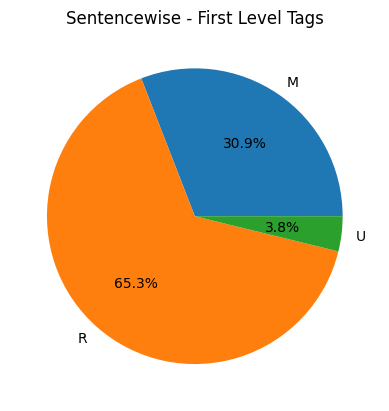

In [117]:
plt.pie(first_sentencewise.values(), labels=first_sentencewise.keys(), autopct='%1.1f%%')
plt.title('Sentencewise - First Level Tags')
plt.show()

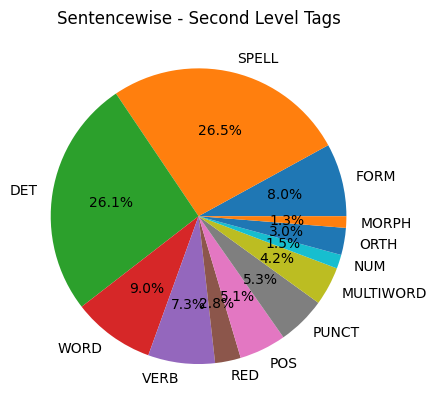

In [114]:
plt.pie(second_sentencewise.values(), labels=second_sentencewise.keys(), autopct='%1.1f%%')
plt.title('Sentencewise - Second Level Tags')
plt.show()

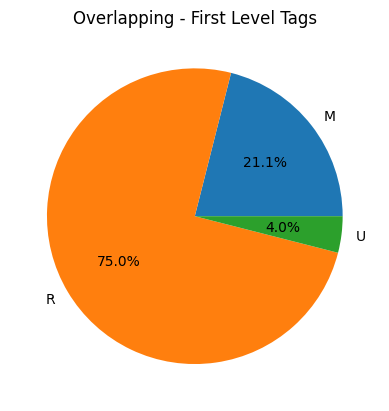

In [115]:
plt.pie(first_overlapping.values(), labels=first_overlapping.keys(), autopct='%1.1f%%')
plt.title('Overlapping - First Level Tags')
plt.show()

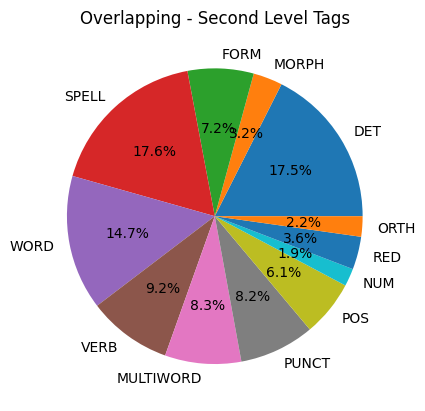

In [116]:
plt.pie(second_overlapping.values(), labels=second_overlapping.keys(), autopct='%1.1f%%')
plt.title('Overlapping - Second Level Tags')
plt.show()

## SpaCy

In [118]:
import spacy
from spacy.tokens import DocBin
from spacy.tokens import SpanGroup
import random
import json
from collections import Counter
import matplotlib.pyplot as plt
import spacy_transformers
from spacy import displacy

In [119]:
nlp = spacy.blank("en")
output_spacy_file = "sentences_binary.spacy"

In [120]:
doc_bin = DocBin()

In [121]:
counter = 0
for entry in sentencewise_data:
    if entry['tags']:
        for mistake in entry['tags']:
             if mistake['first_level_tag']:
                 counter+=1
print(counter)

62827


In [122]:
counter = 0
for entry in sentencewise_data:
    try:
        text = entry["text"]
        annotations = entry["tags"]
        doc = nlp(text)
        spans = []
        for ann in annotations:
            start, end = int(ann["span_start"]), int(ann["span_end"])
            label = "ERROR"
            span = doc.char_span(start, end, label=label)
            spans.append(span)
        group = SpanGroup(doc, name="sc", spans=spans)
        doc.spans["sc"] = group
        doc_bin.add(doc)
        counter+=len(annotations)
    except:
        pass
doc_bin.to_disk(output_spacy_file)

In [123]:
counter

62773

In [124]:
train_ratio = 0.7
dev_ratio = 0.2
test_ratio = 0.1

In [127]:
docs = list(doc_bin.get_docs(nlp.vocab))

In [128]:
total_docs = len(docs)
train_end = int(total_docs * train_ratio)
dev_end = train_end + int(total_docs * dev_ratio)

In [129]:
train_docs = docs[:train_end]
dev_docs = docs[train_end:dev_end]
test_docs = docs[dev_end:]

In [130]:
output_files = {
    "train.spacy": train_docs,
    "dev.spacy": dev_docs,
    "test.spacy": test_docs
}

In [131]:
for filename, doc_subset in output_files.items():
    doc_bin_subset = DocBin()
    for doc in doc_subset:
        doc_bin_subset.add(doc)
    doc_bin_subset.to_disk(filename)

In [133]:
!python -m spacy init config /home/zlovoblachko/diploma/spacy_training/config.cfg --pipeline transformer,spancat --gpu --force

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: spancat
- Optimize for: efficiency
- Hardware: GPU
- Transformer: roberta-base
✔ Auto-filled config with all values
✔ Saved config
/home/zlovoblachko/diploma/spacy_training/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [135]:
!python -m spacy debug data /home/zlovoblachko/GD_correction_diploma/spacy_training/config.cfg


============================ Data file validation ============================
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
✔ Pipeline can be initialized with data
✔ Corpus is loadable

=============================== Training stats ===============================
Language: en
Training pipeline: transformer, spancat
24893 training docs
7112 evaluation docs
⚠ 1 training examples also in evaluation data

============================== Vocab & Vectors ==============================
ℹ 591789 total word(s) in the data (12668 unique)
ℹ No word vectors present in the package

============================ Span Categorization ============================

Spans Key   Labels   
---------   ---------
sc          {'ERROR'}

huggingface/tokenizers: The cur

In [138]:
import spacy
import random
from spacy.tokens import DocBin
from IPython.display import display, HTML

def load_spacy_file(file_path):
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_disk(file_path)
    return list(doc_bin.get_docs(nlp.vocab))

def visualize_spans(doc, span_key="sc"):
    if not doc.spans.get(span_key):
        return doc.text
    
    html = []
    last_pos = 0
    # Sort spans by their start position
    spans = sorted(doc.spans[span_key], key=lambda x: x.start)
    for span in spans:
        html.append(doc.text[last_pos:span.start_char])
        html.append(f'<span style="background-color: #ffcc99; border: 1px solid orange; font-weight: bold">{doc.text[span.start_char:span.end_char]}</span>')
        html.append(f'<sup style="color: green">[{span.label_}]</sup>')
        last_pos = span.end_char
    html.append(doc.text[last_pos:])
    return ''.join(html)

def visualize_random_spans(file_path, num_samples=10, span_key="sc"):
    docs = load_spacy_file(file_path)
    
    if len(docs) < num_samples:
        print(f"Warning: Only {len(docs)} documents found, showing all")
        samples = docs
    else:
        samples = random.sample(docs, num_samples)
    
    for i, doc in enumerate(samples, 1):
        display(HTML(f"<h3>Sample {i}</h3>"))
        display(HTML(f"<p>{visualize_spans(doc, span_key)}</p>"))
        
        if doc.spans.get(span_key):
            table = ["<table border='1'><tr><th>Text</th><th>Label</th><th>Start</th><th>End</th></tr>"]
            for span in doc.spans[span_key]:
                table.append(f"<tr><td>{span.text}</td><td>{span.label_}</td><td>{span.start_char}</td><td>{span.end_char}</td></tr>")
            table.append("</table>")
            display(HTML(''.join(table)))
        else:
            display(HTML(f"<p>No spans found with key '{span_key}' in this sample</p>"))
        display(HTML("<hr>"))

visualize_random_spans("/home/zlovoblachko/GD_correction_diploma/data_preparation/train.spacy", span_key="sc")

Text,Label,Start,End
highlights,ERROR,14,24
hadn't got,ERROR,58,68


Text,Label,Start,End
resons,ERROR,105,111


Text,Label,Start,End
nay,ERROR,52,55
government,ERROR,4,14
going,ERROR,72,77


Text,Label,Start,End
bars,ERROR,41,45
woman,ERROR,54,59


Text,Label,Start,End
minuts,ERROR,38,44
in ages,ERROR,127,134
between 25 and 34,ERROR,135,152


Text,Label,Start,End
Linkedln,ERROR,186,194
people among 65 and more years,ERROR,12,42
on Facebook,ERROR,110,121
percentage,ERROR,99,109
on,ERROR,169,171
and,ERROR,182,185


Text,Label,Start,End
investement,ERROR,3,14


Text,Label,Start,End
american,ERROR,7,15


Text,Label,Start,End
chart,ERROR,80,85


Text,Label,Start,End
have,ERROR,37,41
exercises,ERROR,47,56
tend,ERROR,29,33
the age,ERROR,140,147
